In [1]:
import numpy as np
import scipy
import scipy.stats
import torch as t

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [2]:
%matplotlib inline

In [3]:
device=t.device('cpu') #Overrride the above device choice

### Generate the sample 2D distribution: uniform from unit circle.  

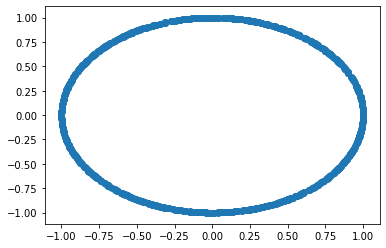

In [4]:
angle = np.random.uniform(-np.pi,np.pi,(1000,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
plt.scatter(data[:,0], data[:,1])

### GAN implementation

In [5]:
discriminator = Sequential(
    Linear(2,50),  
    LeakyReLU(0.2),
    Linear(50, 1), 
    Sigmoid()
) #dummy discriminator: please subsitute you own implementation 

In [6]:
generator = Sequential(
    Linear(2,1000),
    LeakyReLU(0.1),
    
   # Linear(2000,1000),
   # LeakyReLU(0.1),
    
    Linear(1000,500),
    LeakyReLU(0.1),
    
    Linear(500,200),
    LeakyReLU(0.1),
    
    Linear(200,100),
    LeakyReLU(0.1),
    
    Linear(100,100),
    LeakyReLU(0.1),
    
    Linear(100,50),
    LeakyReLU(0.1),
    
    Linear(50, 2),
    LeakyReLU(0.1),
)# dummy generator: please subsitute you own implementation 

In [7]:
discriminator = discriminator.to(device) 
generator= generator.to(device)

d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.001)
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0005)

loss = t.nn.BCELoss()

## Starting here

In [8]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = t.ones(size, 1)

    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = t.zeros(size, 1)

    return data

In [9]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake

In [10]:
def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [11]:
def show(noise, fake, real):
    
    fig, axs = plt.subplots(1,3, figsize = (12,4))
    
    axs[0].set_title("noise")
    axs[1].set_title("fake")
    axs[2].set_title("real")
    
    axs[0].scatter(noise.data.cpu().numpy()[:,0],noise.data.cpu().numpy()[:,1], color = 'gray')
    axs[1].scatter(fake.data.cpu().numpy()[:,0], fake.data.cpu().numpy()[:,1], color = 'red')
    axs[2].scatter(real.data.cpu().numpy()[:,0], real.data.cpu().numpy()[:,1], color = 'green')

    fig.tight_layout()
    plt.show()

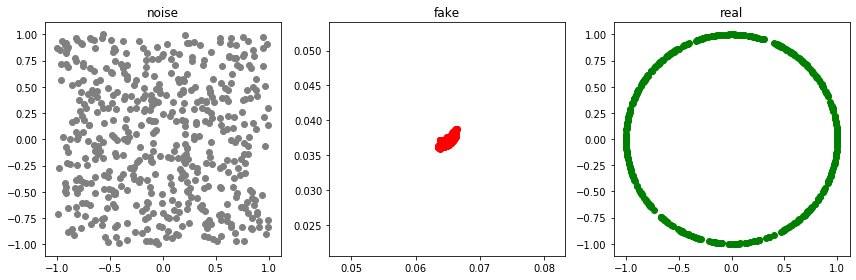

Epoch: 0 G-error: 0.8365709185600281 D-error: 1.3965539932250977


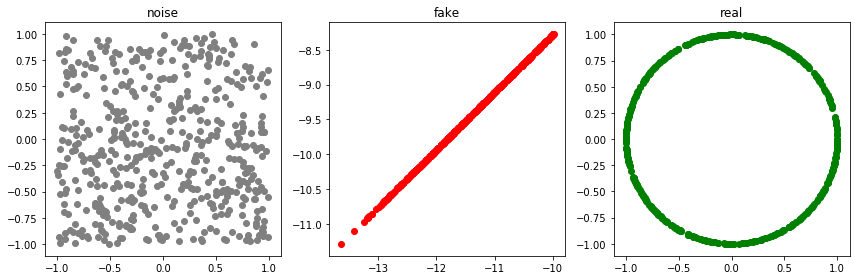

Epoch: 50 G-error: 1.7556273937225342 D-error: 0.9574448466300964


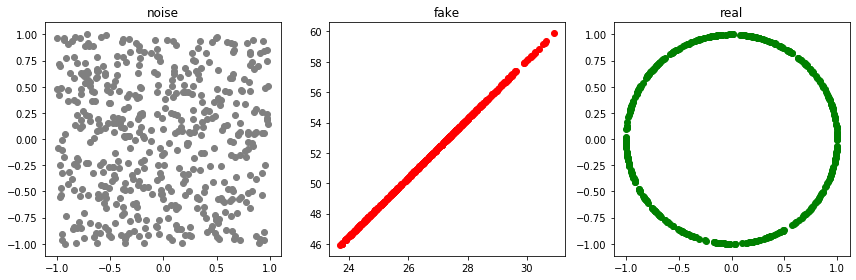

Epoch: 100 G-error: 0.05050014704465866 D-error: 5.294502258300781


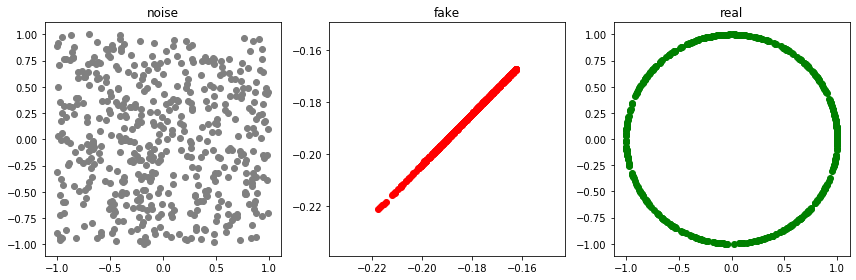

Epoch: 150 G-error: 0.7538160085678101 D-error: 1.4513500928878784


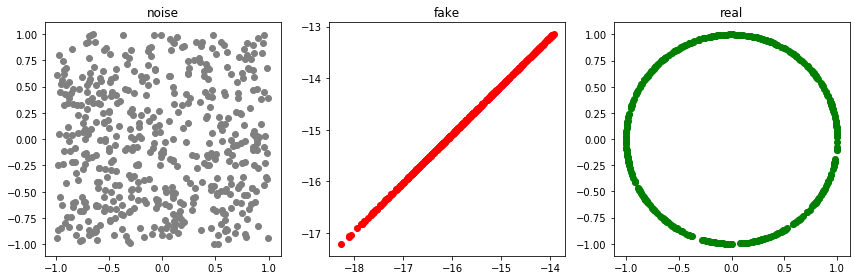

Epoch: 200 G-error: 0.013660354539752007 D-error: 5.57353401184082


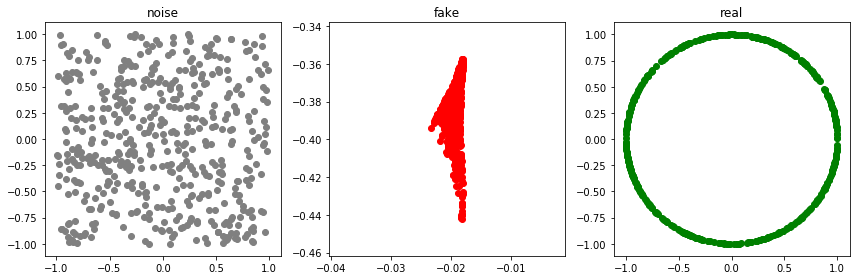

Epoch: 250 G-error: 0.8487929105758667 D-error: 1.461617350578308


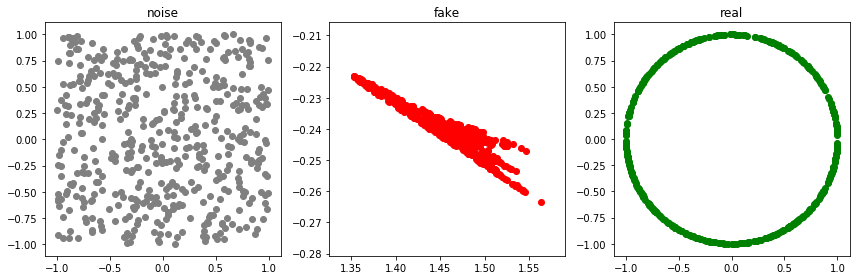

Epoch: 300 G-error: 0.7455679774284363 D-error: 1.5063085556030273


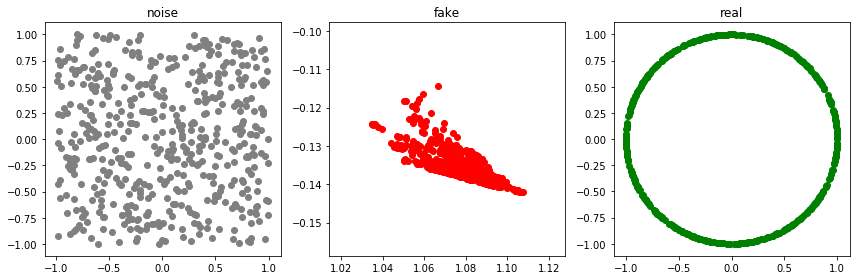

Epoch: 350 G-error: 0.7569106817245483 D-error: 1.4698915481567383


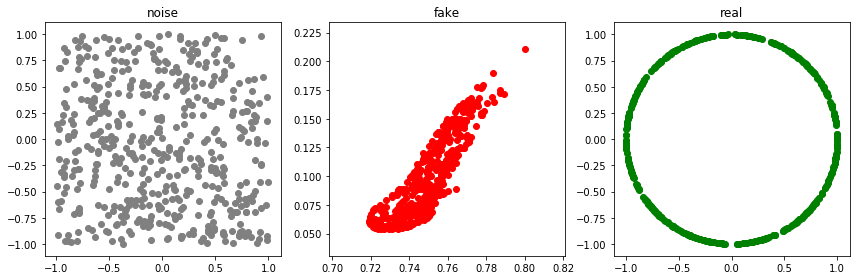

Epoch: 400 G-error: 0.75917649269104 D-error: 1.444870948791504


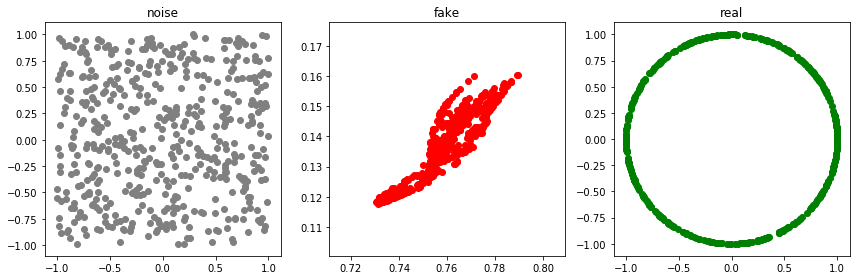

Epoch: 450 G-error: 0.7618528008460999 D-error: 1.4225356578826904


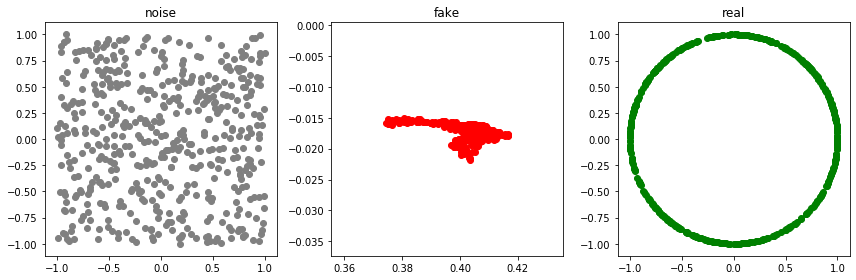

Epoch: 500 G-error: 0.7492163181304932 D-error: 1.415832757949829


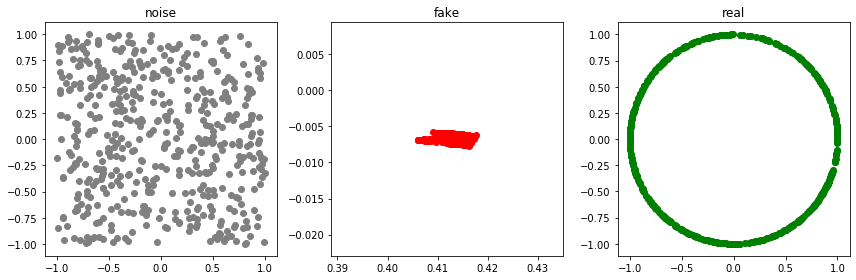

Epoch: 550 G-error: 0.7485253810882568 D-error: 1.4011921882629395


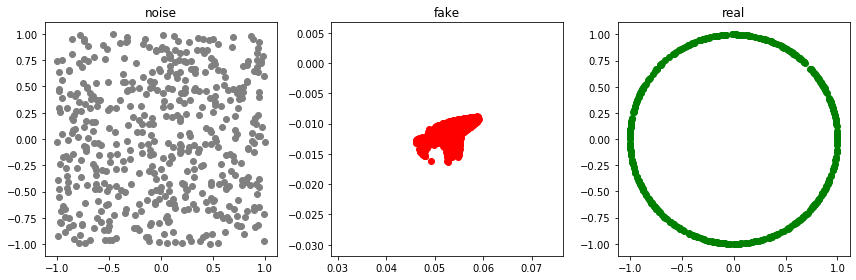

Epoch: 600 G-error: 0.7382145524024963 D-error: 1.398564100265503


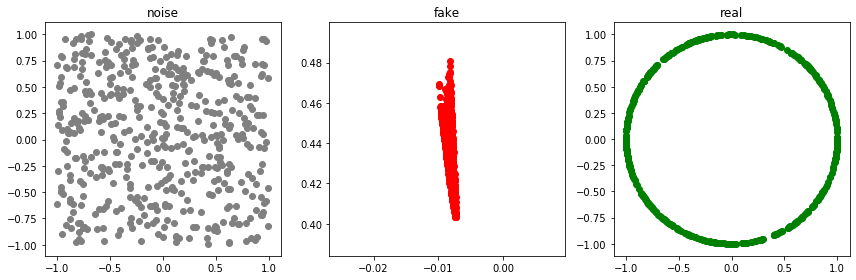

Epoch: 650 G-error: 0.7276754379272461 D-error: 1.3945870399475098


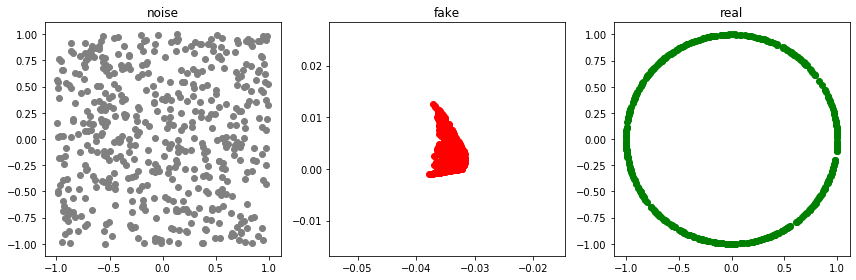

Epoch: 700 G-error: 0.7192456722259521 D-error: 1.3870718479156494


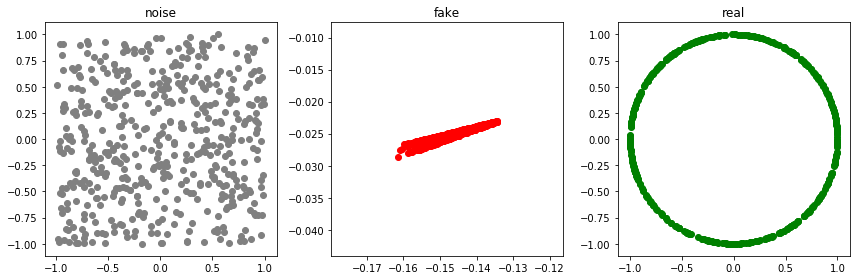

Epoch: 750 G-error: 0.7161142230033875 D-error: 1.3814886808395386


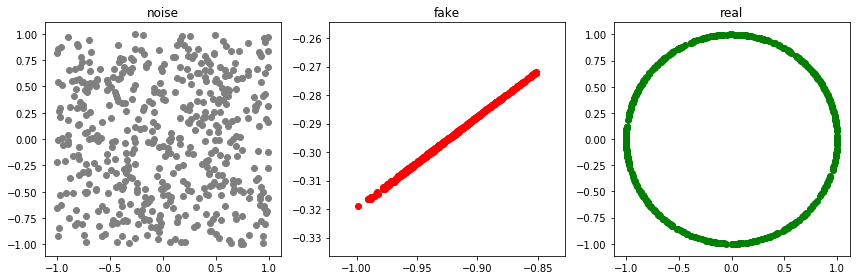

Epoch: 800 G-error: 0.6863213181495667 D-error: 1.4057488441467285


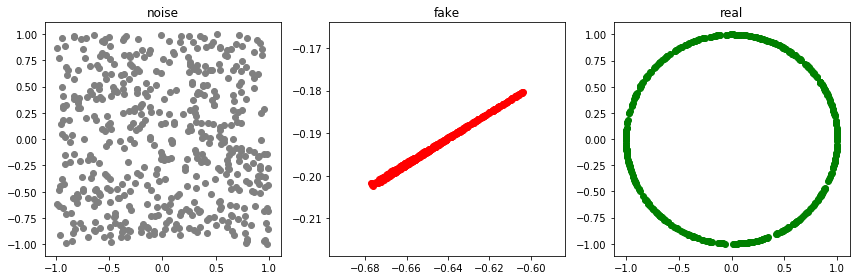

Epoch: 850 G-error: 0.7092934846878052 D-error: 1.3790078163146973


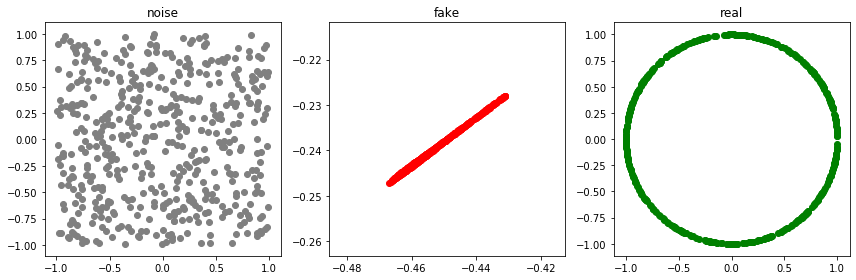

Epoch: 900 G-error: 0.7150909304618835 D-error: 1.364447832107544


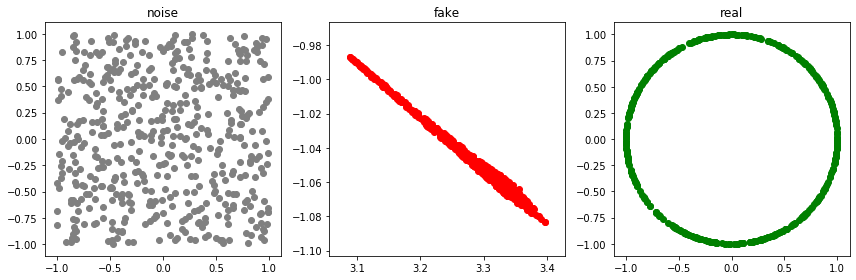

Epoch: 950 G-error: 0.6486607789993286 D-error: 1.4395049810409546


In [12]:
num_epochs = 1000
sample_size = 500

for epoch in range(num_epochs):
    
    # real data
    angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
    data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
    real_data = t.from_numpy(data)
    
    # train discriminator:
    noise = t.empty(sample_size,2, device=device).uniform_(-1,1)
    fake_data = generator(noise).detach()    
    d_error = train_discriminator(d_optimizer, real_data, fake_data)
    
    # train generator       - tryu with detach and without  
    noise = t.empty(sample_size,2, device=device).uniform_(-1,1)
    fake_data = generator(noise)#.detach()    
    g_error = train_generator(g_optimizer, fake_data)

     
    if epoch%50 ==0:
        show(noise, fake_data, real_data)
        print(f"Epoch: {epoch} G-error: {g_error.item()} D-error: {d_error.item()}")


 batch_size = real_batch.shape[0]
        
        # 1. Train Discriminator
        real_data = real_batch
        # Generate fake data
        noise = torch.randn(batch_size, 100)
        fake_data = generator(noise).detach()
        # Train D
        d_error = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        noise = torch.randn(batch_size, 100)
        fake_data = generator(noise)
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error

## Final result

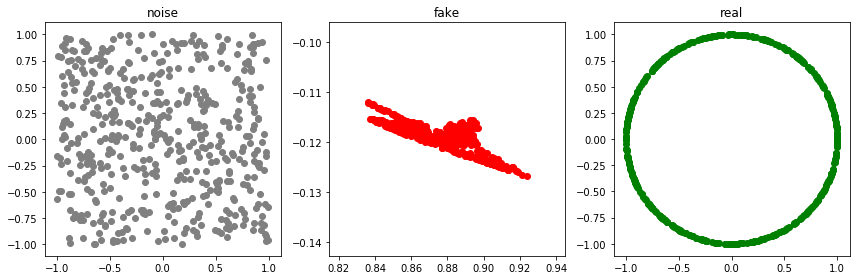

In [13]:
angle = np.random.uniform(-np.pi,np.pi,(sample_size,1)).astype('float32')
data = np.concatenate((np.cos(angle), np.sin(angle)),axis=1)
real_data = t.from_numpy(data)
    
    #fake data:
noise = t.empty(sample_size,2, device=device).uniform_(-1,1)
fake_data = generator(noise).detach()

show(noise, fake_data, real_data)

### Problem 1

Implement the GAN train loop that will train GAN to generate from the sample distribution.  

### Problem 2

Use another sampling distribution. One that is not concentrated on a line e.g. an ellipse. 